# エンゼルの出現確率を予測する

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

import pymc as pm
import scipy.stats as stats

# データの取得
- データはDB（sqlite）に保存されている
    - テーブル定義は、ブログに載っている通り

In [2]:
def get_data(db_file='../data/choco-ball.db', table_name='measurement', filter_str=None):
    """
    dbファイルから計測データを取得する
    
    TODO:
        エラー処理を入れる
    """
    con = sqlite3.connect(db_file)
    sql = 'SELECT '
    sql += 'measure_date,best_before,prd_number,weight,box_weight,ball_number,factory,shop,angel,campaign,taste '
    sql += ', (weight - box_weight), (weight - box_weight)/ball_number '
    sql += 'FROM ' + table_name + ' '
    if filter_str is not None:
        sql += 'WHERE ' + filter_str
    sql += ';'
    sql_result = con.execute(sql)
    res = sql_result.fetchall()
    con.close()
    data = pd.DataFrame(res, columns=['measure_date','best_before','prd_number','weight','box_weight','ball_number','factory','shop','angel','campaign','taste','net_weight','mean_weight'])
    print 'Shape of MeasurementData(record_num, n_columns) : {}'.format(data.shape)
    return data
#data = get_data(filter_str='taste=0')
data = get_data(filter_str='campaign is 1')

Shape of MeasurementData(record_num, n_columns) : (78, 13)


# エンゼル出現確率予測
## 最尤推定

In [5]:
# 最尤推定量
## 金のエンゼル
data_angel_g = np.array([1 if a==2 else 0 for a in data['angel'].values])
p_MLE_g = np.mean(data_angel_g)
## 銀のエンゼル
data_angel_s = np.array([1 if a==1 else 0 for a in data['angel'].values])
p_MLE_s = np.mean(data_angel_s)

print 'gold angel rate(freq):%.3f'%(p_MLE_g)
print 'silver angel rate(freq):%.3f'%(p_MLE_s)

gold angel rate(freq):0.013
silver angel rate(freq):0.000


## ベイズ推定

### モデル
- データ過程：ベルヌーイ分布（確率pで事象が発生し、(1-p)で発生しない）
- 事前分布：一様分布（0~1の実数を取る分布）

 [-----------------100%-----------------] 15000 of 15000 complete in 0.6 secdata_size : (78,)
95% BayesCredibleInterval : 0.0599579793756


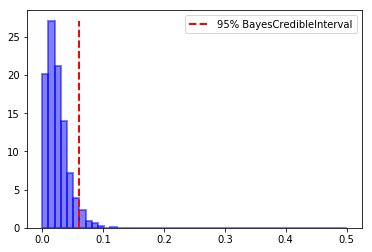

In [6]:
def getMCMCResult(data, n_sample=15000, n_burn=5000):
    """
    MCMCでエンゼルの出現確率を予測する
    Args:
        data:エンゼルの観測結果(array)
        n_sample:MCMCシミュレーションの回数(integer)
        n_burn:捨てる数(integer)
    """
    # 出現確率pの事前分布
    p = pm.Uniform('p', lower=0, upper=1)
    # 観測を結びつける
    obs = pm.Bernoulli('obs', p, value=data, observed=True)
    
    # MCMC
    # Modelオブジェクト生成
    model = pm.Model([p, obs])
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)
    
    return mcmc.trace('p')[:]

p_trace = getMCMCResult(data_angel_g)
ret = plt.hist(p_trace, bins=np.linspace(0, 0.5, 50), normed=True, 
               color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
N = len(p_trace)
bci = np.sort(p_trace)[int(N*0.95)]
plt.vlines(x=bci, ymin=0, ymax=ret[0].max(), label='95% BayesCredibleInterval', 
          color='red', linestyles='--', linewidths=2)
plt.legend()
plt.savefig('fig/estimate_angel_rate_49.png')

print("data_size : {}".format(data_angel_g.shape))
print("95% BayesCredibleInterval : {}".format(bci))

### 観測データ数毎の事後分布の推移

#### 静止画

 [-----------------100%-----------------] 15000 of 15000 complete in 0.5 sec

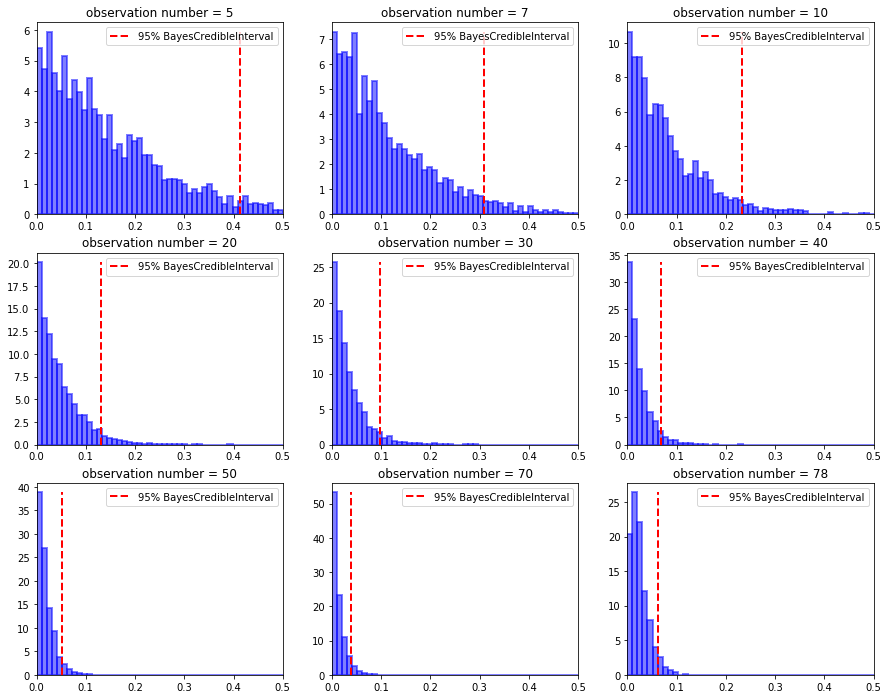

In [10]:
plt.figure(figsize=(15, 12))

#n_list = [2, 5, 10, 20, 30, 43]
n_list = [5, 7, 10, 20, 30, 40, 50, 70, 78]
cnt=0

for n in n_list:
    cnt+=1
    plt.subplot(3,3,cnt)
    p_trace = getMCMCResult(data_angel_g[:n])
    ret = plt.hist(p_trace, bins=np.linspace(0, 0.5, 50), normed=True, 
                   color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
    plt.xlim([0, 0.5])
    N = len(p_trace)
    bci = np.sort(p_trace)[int(N*0.95)]
    plt.vlines(x=bci, ymin=0, ymax=ret[0].max(), label='95% BayesCredibleInterval', 
               color='red', linestyles='--', linewidths=2)
    plt.legend()
    plt.title('observation number = %d'%n)
#plt.savefig('fig/estimate_angel_rate_silver_20171224.png')

In [11]:
bci

0.061687923020526461

In [12]:
p_trace.mean()

0.025223272775480227

In [13]:
np.median(p_trace)

0.021110506571997908

data_size : (78,)
95% BayesCredibleInterval : 0.0616879230205


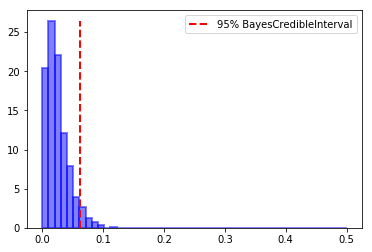

In [14]:
ret = plt.hist(p_trace, bins=np.linspace(0, 0.5, 50), normed=True, 
               color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
N = len(p_trace)
bci = np.sort(p_trace)[int(N*0.95)]
plt.vlines(x=bci, ymin=0, ymax=ret[0].max(), label='95% BayesCredibleInterval', 
          color='red', linestyles='--', linewidths=2)
plt.legend()
plt.savefig('fig/estimate_angel_rate_silver_9.png')

print("data_size : {}".format(data_angel_g.shape))
print("95% BayesCredibleInterval : {}".format(bci))